In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("ReadySoilDataset_Final.csv")
df = df[df['Region'].isin([2,4,5,7])].reset_index(drop=True)
df.head(10)

,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0.0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1.0,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33.0,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46.0,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402.0,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386.0,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202.0,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205.0,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209.0,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177.0,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [6]:


# === 1. Feature / target selection ===========================================
features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 
               'Rainfall', 'Surface Pressure']]
target = df['SoilTemperature-50']

# === 2. Scaling ==============================================================
feat_scaler = StandardScaler()
X_scaled = feat_scaler.fit_transform(features)

tgt_scaler = MinMaxScaler()
y_scaled = tgt_scaler.fit_transform(target.values.reshape(-1, 1))

# === 3. Sliding-window sequencing ============================================
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 12
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

# === 4. Train / val / test split =============================================
X_train, X_tmp, y_train, y_tmp = train_test_split(X_seq, y_seq,
                                                  test_size=0.2,
                                                  random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp,
                                                test_size=0.5,
                                                random_state=2)

# === 5. Model definition (SimpleRNN stack) ===================================
model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True,
              input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)                           # linear output for regression
])

# === 6. Compile ==============================================================
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# === 7. Callbacks ============================================================
early_stop  = EarlyStopping(monitor='val_loss',
                            patience=10,
                            restore_best_weights=True)
checkpoint  = ModelCheckpoint('best_simple_rnn.h5',
                              monitor='val_loss',
                              save_best_only=True,
                              mode='min')
lr_sched    = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=1e-6)

# === 8. Training =============================================================
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)

# === 9. Evaluation ===========================================================
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE:       {mae:.4f}")

# === 10. Prediction & inverse-scaling ========================================
y_pred_scaled = model.predict(X_test)
y_pred        = tgt_scaler.inverse_transform(y_pred_scaled)
y_true        = tgt_scaler.inverse_transform(y_test)

comparison = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual':    y_true.flatten()
})
print(comparison.head(14))


Epoch 1/100
27/27 [==============================] - 4s 31ms/step - loss: 0.3961 - mae: 0.4996 - val_loss: 0.0895 - val_mae: 0.2578 - lr: 0.0010
Epoch 2/100
 8/27 [=======>......................] - ETA: 0s - loss: 0.1195 - mae: 0.2737

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 13ms/step - loss: 0.1038 - mae: 0.2602 - val_loss: 0.0176 - val_mae: 0.1057 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.0824 - mae: 0.2256 - val_loss: 0.0184 - val_mae: 0.1095 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0655 - mae: 0.2028 - val_loss: 0.0134 - val_mae: 0.0903 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0539 - mae: 0.1791 - val_loss: 0.0143 - val_mae: 0.0929 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0476 - mae: 0.1728 - val_loss: 0.0105 - val_mae: 0.0818 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0452 - mae: 0.1684 - val_loss: 0.0111 - val_mae: 0.0827 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.0425 - mae: 0.1601 - val_loss: 0.0124 - val_mae: 0.0864 - lr: 0.00

In [ ]:
Test Loss (MSE): 0.0081
Test MAE:       0.0675

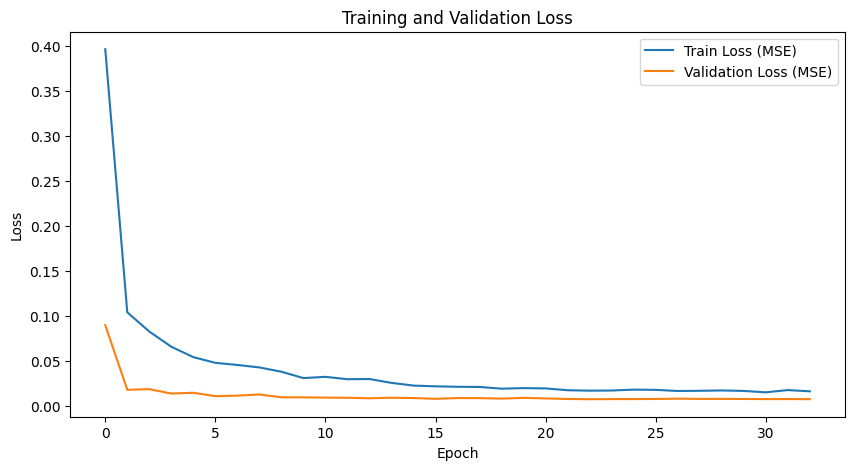

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()